In [3]:
import re
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout, Embedding, LSTM, SpatialDropout1D, Input, Concatenate, Bidirectional
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

In [4]:
df = pd.read_csv("/kaggle/input/processed-sub/processed_all_text.csv")

In [5]:
df.head(3)

,id,num_comments,score,upvote_ratio,all_text,hour,Class,body_len
0,x2wyl4,1.0,1.0,1.0,I can't even eat chocolate without thinking ab...,10,1,356
1,x2uv4c,1.0,1.0,1.0,How do I know he's really changing? I think th...,8,1,380
2,x2pn4w,1.0,1.0,1.0,Just got my 5th NFA 😭 This is more of a rant t...,4,1,732


In [6]:
df.Class.value_counts()

0    233426
1     10276
Name: Class, dtype: int64

In [4]:
sample_text = df['all_text'].iloc[11]
sample_text

"ladies please take warning and stay aware from him https://www.tiktok.com/t/ZTRPL4whN/\n\nI'm trying to spread awareness to all so u don't go through the physical and emotional abuse that he put me through.... ais there any advice to help recover?"

In [ ]:
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', 
                                      action="insert", device='cuda')

In [ ]:
augmented_sample_text = augmenter.augment(sample_text)
augmented_sample_text

["ladies please take warning and stay aware only from him https : / / www. tiktok. at com / [UNK] t / the ztrpl4whn / [UNK] i'm trying to spread awareness to all so hope u don't just go through the physical and emotional abuse spells that he put his me through.... ais there any advice here to help recover?"]

In [ ]:
for i in range(5):
    print(augmenter.augment(sample_text))

["ladies first please just take a warning and stay aware email from him https : / / www. david tiktok. com / t / ztrpl4whn / i'm trying harder to spread awareness to all youth so u will don't go through the physical and emotional abuse that he put me through.... ais there iss any advice enough to help recover?"]
["now ladies please take warning and stay more aware and from him https : / / www. tiktok. com / t / ztrpl4whn / i'm trying to spread awareness to them all so u please don't go rushing through about the terrible physical and and emotional abuse that man he put me through.... ais there any advice to help recover?"]
["ladies please take warning and stay quite aware from watching him https : / / dot www. tiktok. com / t / ztrpl4whn / but i'm trying to spread awareness to all children so u don't go going through the physical and emotional anxiety abuse that he put me through.... to ais there is any additional advice to help recover?"]
["so ladies please all take your warning and st

In [6]:
df['Class'].value_counts()

0    233426
1     10276
Name: Class, dtype: int64

In [ ]:
def augmentMyData(df, augmenter, repetitions=1, samples=40000):
    augmented_texts = []
    # select only the minority class samples
    dv_df = df[df['Class'] == 1].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(dv_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(dv_df['all_text'].iloc[i])
            augmented_texts.append(augmented_text)
    
    data = {
        'Class': 1,
        'all_text': augmented_texts
    }
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df

In [6]:
new_df = df[['Class', 'all_text']]
new_df.head()

,Class,all_text
0,1,I can't even eat chocolate without thinking ab...
1,1,How do I know he's really changing? I think th...
2,1,Just got my 5th NFA 😭 This is more of a rant t...
3,1,"Can't find the energy to leave Hi, I have been..."
4,1,Am I really at a point where I should avoid do...


In [ ]:
aug_df = augmentMyData(new_df, augmenter, samples=60000)

In [ ]:
aug_df.to_csv('aug_df.csv', index=False)

In [7]:
aug_df= pd.read_csv("/kaggle/input/augmented-df/aug_df.csv")
aug_df.head()

,Class,all_text
0,1,['surviving the holidays i left my abusive hus...
1,0,How do I (22M) tell the girl I like (20F) the ...
2,0,What do you call an angry German? Sauerkraut
3,1,['please help. hello. i am a teen. my brothers...
4,0,My local supermarket was selling a pallet of 2...


In [8]:
aug_df.Class.value_counts()

0    233426
1     70276
Name: Class, dtype: int64

In [23]:
print("Original: ", df.shape)
print("Augmented: ", aug_df.shape)

Original:  (243702, 8)
Augmented:  (303702, 2)


In [9]:
train_data, val_data= train_test_split(df, test_size=0.6, random_state=25)
val_data, test_data= train_test_split(val_data, test_size=0.5, random_state=25)
train_data.shape,  val_data.shape, test_data.shape

((97480, 8), (73111, 8), (73111, 8))

In [11]:
train_data.Class.value_counts()

0    93335
1     4145
Name: Class, dtype: int64

In [12]:
aug_train_data, _ = train_test_split(aug_df, test_size=0.6, random_state=25)
aug_train_data.shape

(121480, 2)

In [13]:
aug_train_data.Class.value_counts()

0    93329
1    28151
Name: Class, dtype: int64

In [14]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH =500
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(aug_df['all_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 161644 unique tokens.


In [15]:
X_train=train_data['all_text']
aug_X_train=aug_train_data['all_text']
y_train = train_data.Class
aug_y_train=aug_train_data.Class

X_val=val_data['all_text']
y_val = val_data.Class

X_test=test_data['all_text']
y_test = test_data.Class
X_train.shape, y_train.shape, aug_X_train.shape, aug_y_train.shape

((97480,), (97480,), (121480,), (121480,))

In [16]:
X_val.shape,X_test.shape, y_val.shape,y_test.shape

((73111,), (73111,), (73111,), (73111,))

In [17]:
#create sequences for vinila LSTM model
X_vect_train = tokenizer.texts_to_sequences(X_train.values)
X_vect_train = pad_sequences(X_vect_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of X_train data tensor:', X_vect_train.shape)

aug_X_vect_train = tokenizer.texts_to_sequences(aug_X_train.values)
aug_X_vect_train = pad_sequences(aug_X_vect_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of aug_X_train data tensor:', aug_X_vect_train.shape)

X_vect_val = tokenizer.texts_to_sequences(X_val.values)
X_vect_val = pad_sequences(X_vect_val, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of X_val data tensor:', X_vect_val.shape)

X_vect_test = tokenizer.texts_to_sequences(X_test.values)
X_vect_test = pad_sequences(X_vect_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of X_test data tensor:', X_vect_test.shape)

Shape of X_train data tensor: (97480, 500)
Shape of aug_X_train data tensor: (121480, 500)
Shape of X_val data tensor: (73111, 500)
Shape of X_test data tensor: (73111, 500)


In [18]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

CALLBACKS=[EarlyStopping(monitor='val_prc', verbose=1,patience=5, mode='max',restore_best_weights=True)]

EPOCHS = 20

### 1. unaugmented dataset

In [19]:
modelV0 = Sequential()
modelV0.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_vect_train.shape[1]))
modelV0.add(SpatialDropout1D(0.6))
modelV0.add(LSTM(64, dropout=0.6, recurrent_dropout=0))
modelV0.add(Dense(1, activation='sigmoid'))
modelV0.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=METRICS)
print(modelV0.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,042,305
Trainable params: 5,042,305
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
historyV0 = modelV0.fit(
    X_vect_train, 
    y_train,
    batch_size=32,
    epochs=EPOCHS,
    validation_data=(X_vect_val, y_val),
    callbacks=CALLBACKS)

Epoch 1/20
3047/3047 [==============================] - 218s 68ms/step - loss: 0.1593 - tp: 201.0000 - fp: 151.0000 - tn: 93184.0000 - fn: 3944.0000 - accuracy: 0.9580 - precision: 0.5710 - recall: 0.0485 - auc: 0.7068 - prc: 0.1699 - val_loss: 0.0969 - val_tp: 1548.0000 - val_fp: 660.0000 - val_tn: 69418.0000 - val_fn: 1485.0000 - val_accuracy: 0.9707 - val_precision: 0.7011 - val_recall: 0.5104 - val_auc: 0.9146 - val_prc: 0.5474
Epoch 2/20
3047/3047 [==============================] - 97s 32ms/step - loss: 0.1026 - tp: 1827.0000 - fp: 844.0000 - tn: 92491.0000 - fn: 2318.0000 - accuracy: 0.9676 - precision: 0.6840 - recall: 0.4408 - auc: 0.9004 - prc: 0.5378 - val_loss: 0.1121 - val_tp: 710.0000 - val_fp: 181.0000 - val_tn: 69897.0000 - val_fn: 2323.0000 - val_accuracy: 0.9658 - val_precision: 0.7969 - val_recall: 0.2341 - val_auc: 0.8831 - val_prc: 0.5831
Epoch 3/20
3047/3047 [==============================] - 91s 30ms/step - loss: 0.0958 - tp: 2054.0000 - fp: 862.0000 - tn: 92473.0

In [36]:
modelV0.save('LSTM_model_V0.h5')

In [18]:
#modelV0=tf.keras.models.load_model('aug_LSTM_model_V0.h5')

In [70]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
sns.set_palette("Paired")

In [22]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

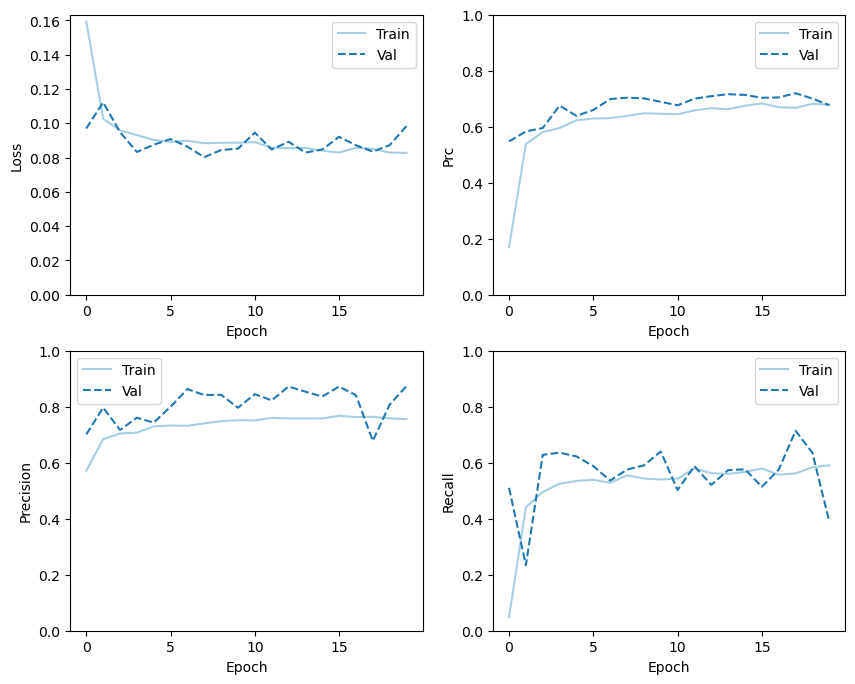

In [71]:
plot_metrics(historyV0)

In [24]:
### create confusion matrix to summarize the actual vs. predicted labels

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  group_names = ['TN','FP','FN','TP']
  group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=labels, fmt='', cmap='Blues');
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('non_dv posts Detected (True Negatives): ', cm[0][0])
  print('non_dv posts Incorrectly Detected (False Positives): ', cm[0][1])
  print('dv posts Missed (False Negatives): ', cm[1][0])
  print('dv posts Detected (True Positives): ', cm[1][1])
  print('Total dv posts: ', np.sum(cm[1]))

2285/2285 [==============================] - 15s 7ms/step
non_dv posts Detected (True Negatives):  69807
non_dv posts Incorrectly Detected (False Positives):  206
dv posts Missed (False Negatives):  1936
dv posts Detected (True Positives):  1162
Total dv posts:  3098


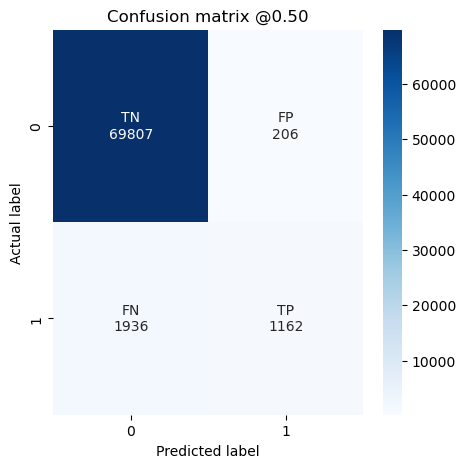

In [79]:
train_predictions_modelV0 = modelV0.predict(X_vect_train, batch_size=32)
test_predictions_modelV0 = modelV0.predict(X_vect_test, batch_size=32)

plot_cm(y_test, test_predictions_modelV0)

In [80]:
predict_classes_V0=(test_predictions_modelV0 > 0.5).astype("int32")
print("modelV0 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V0)))

modelV0 Classification report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     70013
           1       0.85      0.38      0.52      3098

    accuracy                           0.97     73111
   macro avg       0.91      0.69      0.75     73111
weighted avg       0.97      0.97      0.97     73111



In [27]:
# Plot the AUPRC
import sklearn
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

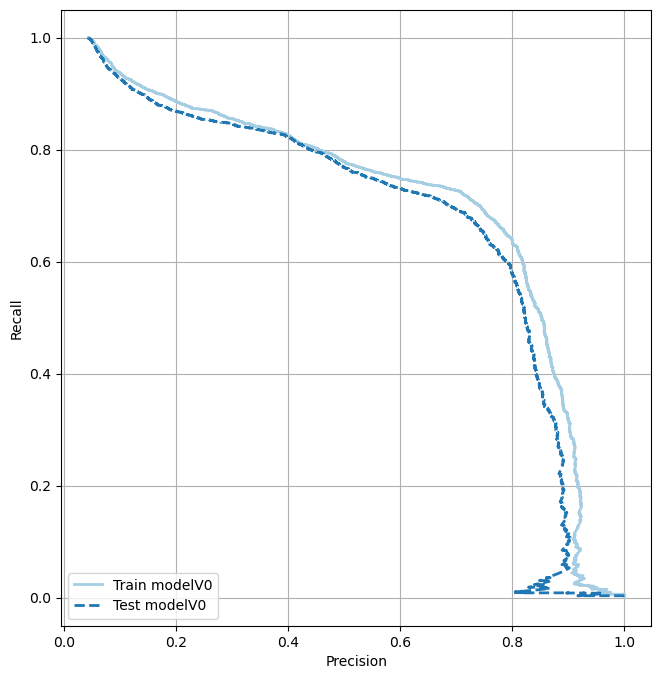

In [81]:
plot_prc("Train modelV0", y_train, train_predictions_modelV0)
plot_prc("Test modelV0", y_test, test_predictions_modelV0,linestyle='--')
plt.legend(loc='lower left');

### 2. augmented dataset

In [29]:
aug_modelV0 = Sequential()
aug_modelV0.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_vect_train.shape[1]))
aug_modelV0.add(SpatialDropout1D(0.6))
aug_modelV0.add(LSTM(64, dropout=0.6, recurrent_dropout=0))
aug_modelV0.add(Dense(1, activation='sigmoid'))
aug_modelV0.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=METRICS)
print(aug_modelV0.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 500, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,042,305
Trainable params: 5,042,305
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
aug_historyV0 = aug_modelV0.fit(
    aug_X_vect_train, 
    aug_y_train,
    batch_size=32,
    epochs=EPOCHS,
    validation_data=(X_vect_val, y_val),
    callbacks=CALLBACKS)

Epoch 1/20
3797/3797 [==============================] - 175s 45ms/step - loss: 0.1401 - tp: 25513.0000 - fp: 2324.0000 - tn: 161083.0000 - fn: 5671.0000 - accuracy: 0.9589 - precision: 0.9165 - recall: 0.8181 - auc: 0.9713 - prc: 0.9324 - val_loss: 0.0630 - val_tp: 2367.0000 - val_fp: 811.0000 - val_tn: 69267.0000 - val_fn: 666.0000 - val_accuracy: 0.9798 - val_precision: 0.7448 - val_recall: 0.7804 - val_auc: 0.9741 - val_prc: 0.7762
Epoch 2/20
3797/3797 [==============================] - 106s 28ms/step - loss: 0.1054 - tp: 25606.0000 - fp: 1823.0000 - tn: 91506.0000 - fn: 2545.0000 - accuracy: 0.9640 - precision: 0.9335 - recall: 0.9096 - auc: 0.9865 - prc: 0.9713 - val_loss: 0.0622 - val_tp: 2450.0000 - val_fp: 866.0000 - val_tn: 69212.0000 - val_fn: 583.0000 - val_accuracy: 0.9802 - val_precision: 0.7388 - val_recall: 0.8078 - val_auc: 0.9760 - val_prc: 0.8067
Epoch 3/20
3797/3797 [==============================] - 103s 27ms/step - loss: 0.1021 - tp: 25716.0000 - fp: 1795.0000 - tn

In [ ]:
aug_modelV0.save('aug_modelV0.h5')

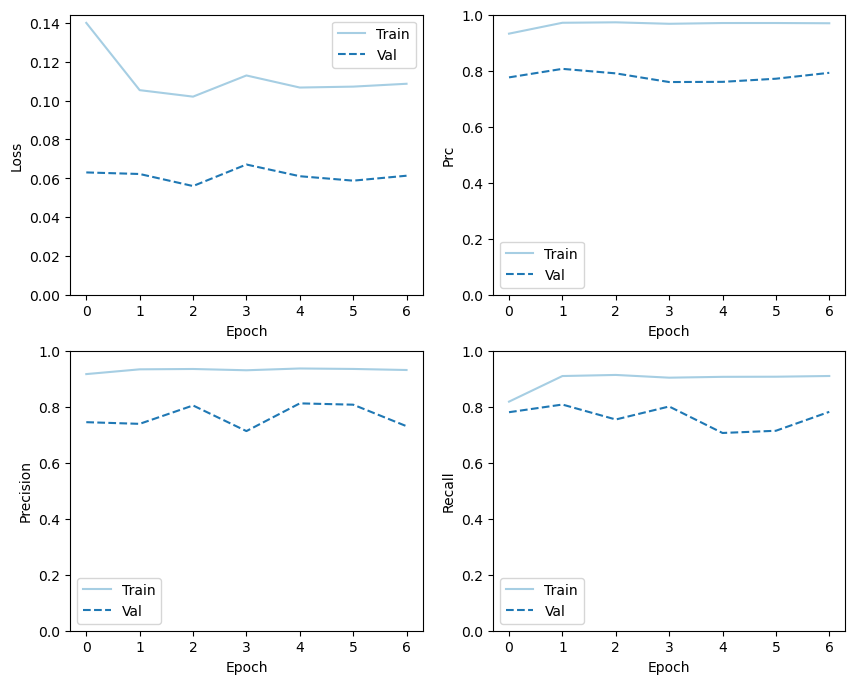

In [73]:
plot_metrics(aug_historyV0)

In [82]:
test_predictions_aug_modelV0 = aug_modelV0.predict(X_vect_test, batch_size=32)
aug_predict_classes_V0=(test_predictions_aug_modelV0 > 0.5).astype("int32")
print("modelV0 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V0)))

2285/2285 [==============================] - 17s 7ms/step
modelV0 Classification report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     70013
           1       0.85      0.38      0.52      3098

    accuracy                           0.97     73111
   macro avg       0.91      0.69      0.75     73111
weighted avg       0.97      0.97      0.97     73111



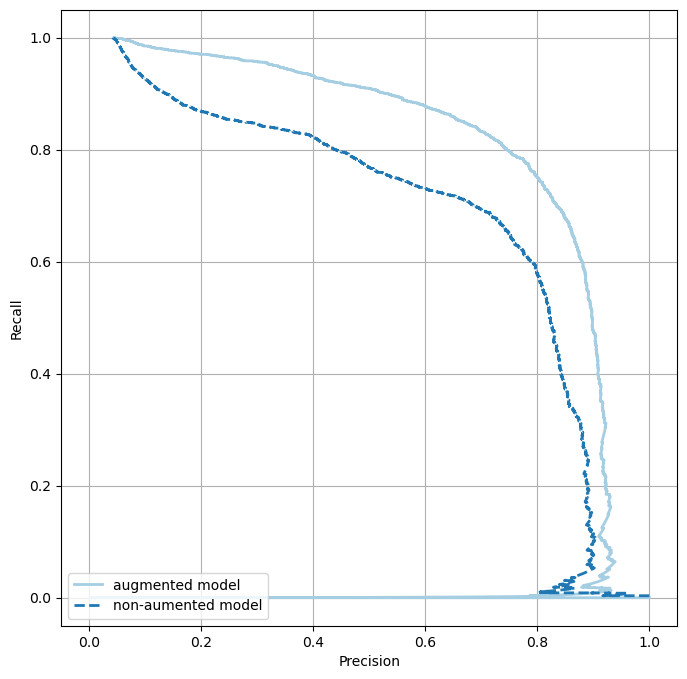

In [83]:
plot_prc("augmented model", y_test, test_predictions_aug_modelV0)
plot_prc("non-aumented model", y_test, test_predictions_modelV0,linestyle='--')
plt.legend(loc='lower left');

### 3. undersampling method with augmented data

In [40]:
# Class count
count_class_0, count_class_1 = aug_train_data.Class.value_counts()

# Divide by class
df_class_0 = aug_train_data[aug_train_data['Class'] == 0]
df_class_1 = aug_train_data[aug_train_data['Class'] == 1]
count_class_0, count_class_1

(93329, 28151)

In [41]:
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_under.Class.value_counts())

Random under-sampling:
0    28151
1    28151
Name: Class, dtype: int64


In [42]:
X_train_under=df_under['all_text']
y_train_under = df_under.Class

X_train_under.shape, y_train_under.shape

((56302,), (56302,))

In [43]:
X_vect_train_under = tokenizer.texts_to_sequences(X_train_under.values)
X_vect_train_under = pad_sequences(X_vect_train_under, maxlen=MAX_SEQUENCE_LENGTH)

In [44]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

CALLBACKS=[EarlyStopping(monitor='val_prc', verbose=1,patience=3, mode='max',restore_best_weights=True)]

EPOCHS = 20

In [45]:
aug_modelV1 = Sequential()
aug_modelV1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_vect_train.shape[1]))
aug_modelV1.add(SpatialDropout1D(0.4))
aug_modelV1.add(LSTM(64, dropout=0.4, recurrent_dropout=0))
aug_modelV1.add(Dense(4, activation='relu'))
aug_modelV1.add(Dense(1, activation='sigmoid'))
aug_modelV1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=METRICS)
print(aug_modelV1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 500, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 5,042,505
Trainable params: 5,042,505
Non-trainable params: 0
____________________________________________

In [46]:
aug_historyV1 = aug_modelV1.fit(
    X_vect_train_under, 
    y_train_under,
    batch_size=32,
    epochs=EPOCHS,
    validation_data=(X_vect_val, y_val),
    callbacks=CALLBACKS)

Epoch 1/20
1760/1760 [==============================] - 119s 65ms/step - loss: 0.1628 - tp: 26169.0000 - fp: 1609.0000 - tn: 26542.0000 - fn: 1982.0000 - accuracy: 0.9362 - precision: 0.9421 - recall: 0.9296 - auc: 0.9832 - prc: 0.9846 - val_loss: 0.0877 - val_tp: 2800.0000 - val_fp: 2307.0000 - val_tn: 67771.0000 - val_fn: 233.0000 - val_accuracy: 0.9653 - val_precision: 0.5483 - val_recall: 0.9232 - val_auc: 0.9868 - val_prc: 0.8219
Epoch 2/20
1760/1760 [==============================] - 65s 37ms/step - loss: 0.0754 - tp: 27342.0000 - fp: 696.0000 - tn: 27455.0000 - fn: 809.0000 - accuracy: 0.9733 - precision: 0.9752 - recall: 0.9713 - auc: 0.9958 - prc: 0.9959 - val_loss: 0.0850 - val_tp: 2816.0000 - val_fp: 1753.0000 - val_tn: 68325.0000 - val_fn: 217.0000 - val_accuracy: 0.9731 - val_precision: 0.6163 - val_recall: 0.9285 - val_auc: 0.9899 - val_prc: 0.8544
Epoch 3/20
1760/1760 [==============================] - 63s 36ms/step - loss: 0.0631 - tp: 27503.0000 - fp: 574.0000 - tn: 27

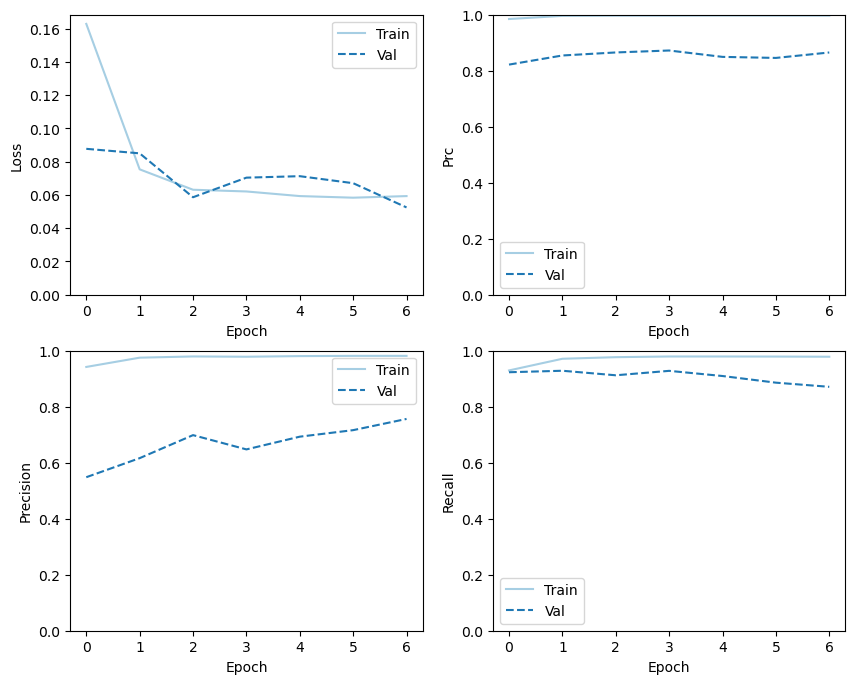

In [75]:
plot_metrics(aug_historyV1)

In [84]:
test_predictions_modelV1 = aug_modelV1.predict(X_vect_test, batch_size=32)
predict_classes_V1=(test_predictions_modelV1 > 0.5).astype("int32")
print("ModelV1 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V1)))

2285/2285 [==============================] - 16s 7ms/step
ModelV1 Classification report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70013
           1       0.65      0.92      0.77      3098

    accuracy                           0.98     73111
   macro avg       0.83      0.95      0.88     73111
weighted avg       0.98      0.98      0.98     73111



In [85]:
predict_classes_V1_40=(test_predictions_modelV1 > 0.4).astype("int32")
print(classification_report(y_test,predict_classes_V1_40))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     70013
           1       0.62      0.94      0.74      3098

    accuracy                           0.97     73111
   macro avg       0.81      0.96      0.86     73111
weighted avg       0.98      0.97      0.98     73111



In [86]:
predict_classes_V1_90=(test_predictions_modelV1 > 0.9).astype("int32")
print(classification_report(y_test,predict_classes_V1_90))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     70013
           1       0.82      0.82      0.82      3098

    accuracy                           0.98     73111
   macro avg       0.91      0.91      0.91     73111
weighted avg       0.98      0.98      0.98     73111



In [87]:
predict_classes_V1_80=(test_predictions_modelV1 > 0.8).astype("int32")
print(classification_report(y_test,predict_classes_V1_80))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     70013
           1       0.77      0.87      0.82      3098

    accuracy                           0.98     73111
   macro avg       0.88      0.93      0.90     73111
weighted avg       0.98      0.98      0.98     73111



In [88]:
predict_classes_V1_70=(test_predictions_modelV1 > 0.7).astype("int32")
print(classification_report(y_test,predict_classes_V1_70))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     70013
           1       0.73      0.89      0.80      3098

    accuracy                           0.98     73111
   macro avg       0.86      0.94      0.90     73111
weighted avg       0.98      0.98      0.98     73111



In [48]:
modelV1.save('aug_LSTM_model_V1.h5')

### 4.  undersampling using augmented dataset with example weight

In [54]:
example_weight=count_class_0/ count_class_1
example_weight

3.315299634116017

In [55]:
EXAMPLE_WEIGHT= {0: example_weight, 1: 1}

In [58]:
aug_modelV2 = Sequential()
aug_modelV2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_vect_train.shape[1]))
aug_modelV2.add(SpatialDropout1D(0.4))
aug_modelV2.add(LSTM(64, dropout=0.4, recurrent_dropout=0))
aug_modelV2.add(Dense(4, activation='relu'))
aug_modelV2.add(Dense(1, activation='sigmoid'))
aug_modelV2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=METRICS)
print(aug_modelV2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 500, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dense_6 (Dense)             (None, 4)                 260       
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 5,042,505
Trainable params: 5,042,505
Non-trainable params: 0
____________________________________________

In [59]:

CALLBACKS=[EarlyStopping(monitor='val_prc', verbose=1,patience=5, mode='max',restore_best_weights=True)]

aug_historyV2 = aug_modelV2.fit(
    X_vect_train_under, 
    y_train_under,
    batch_size=32,
    epochs=EPOCHS,
    class_weight=EXAMPLE_WEIGHT,
    validation_data=(X_vect_val, y_val),
    callbacks=CALLBACKS)

Epoch 1/20
1760/1760 [==============================] - 117s 64ms/step - loss: 0.3050 - tp: 36599.0000 - fp: 859.0000 - tn: 41054.0000 - fn: 5278.0000 - accuracy: 0.9268 - precision: 0.9771 - recall: 0.8740 - auc: 0.9868 - prc: 0.9879 - val_loss: 0.0608 - val_tp: 2489.0000 - val_fp: 978.0000 - val_tn: 69100.0000 - val_fn: 544.0000 - val_accuracy: 0.9792 - val_precision: 0.7179 - val_recall: 0.8206 - val_auc: 0.9798 - val_prc: 0.7979
Epoch 2/20
1760/1760 [==============================] - 64s 37ms/step - loss: 0.1484 - tp: 26566.0000 - fp: 413.0000 - tn: 27738.0000 - fn: 1585.0000 - accuracy: 0.9645 - precision: 0.9847 - recall: 0.9437 - auc: 0.9946 - prc: 0.9952 - val_loss: 0.0457 - val_tp: 2626.0000 - val_fp: 800.0000 - val_tn: 69278.0000 - val_fn: 407.0000 - val_accuracy: 0.9835 - val_precision: 0.7665 - val_recall: 0.8658 - val_auc: 0.9854 - val_prc: 0.8625
Epoch 3/20
1760/1760 [==============================] - 60s 34ms/step - loss: 0.1183 - tp: 26996.0000 - fp: 369.0000 - tn: 2778

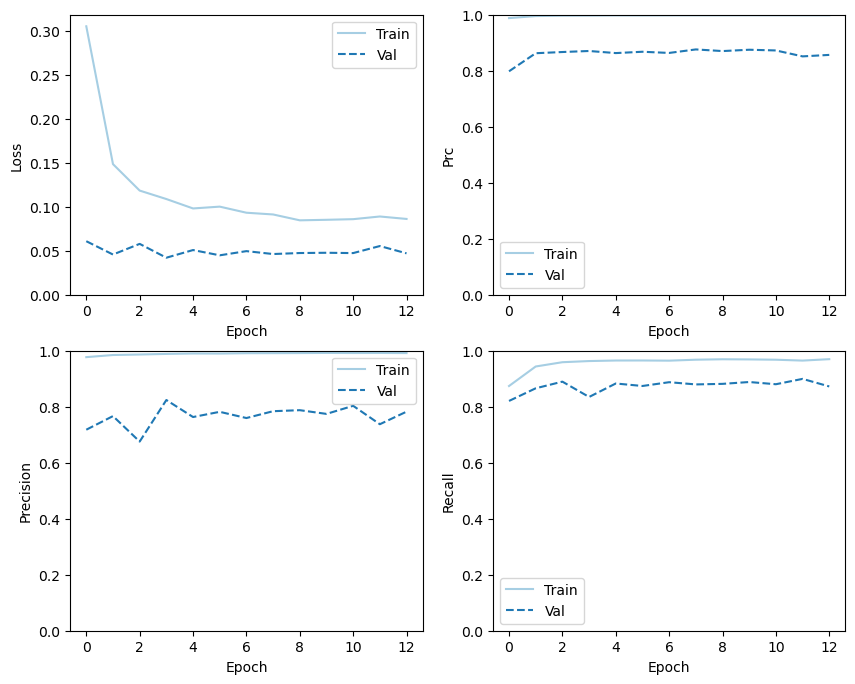

In [76]:
plot_metrics(aug_historyV2)

In [89]:
test_predictions_modelV2 = aug_modelV2.predict(X_vect_test, batch_size=32)
predict_classes_V2=(test_predictions_modelV2 > 0.5).astype("int32")
print("ModelV1 Classification report:\n\n{}".format(classification_report(y_test, predict_classes_V2)))

2285/2285 [==============================] - 19s 8ms/step
ModelV1 Classification report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     70013
           1       0.79      0.88      0.83      3098

    accuracy                           0.99     73111
   macro avg       0.89      0.93      0.91     73111
weighted avg       0.99      0.99      0.99     73111



In [90]:
predict_classes_V2_90=(test_predictions_modelV2 > 0.9).astype("int32")
print(classification_report(y_test,predict_classes_V2_90))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     70013
           1       0.87      0.76      0.81      3098

    accuracy                           0.99     73111
   macro avg       0.93      0.88      0.90     73111
weighted avg       0.98      0.99      0.98     73111



In [91]:
predict_classes_V2_40=(test_predictions_modelV2 > 0.4).astype("int32")
print(classification_report(y_test,predict_classes_V2_40))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     70013
           1       0.77      0.89      0.83      3098

    accuracy                           0.98     73111
   macro avg       0.88      0.94      0.91     73111
weighted avg       0.99      0.98      0.98     73111



In [92]:
predict_classes_V2_80=(test_predictions_modelV2 > 0.8).astype("int32")
print(classification_report(y_test,predict_classes_V2_80))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     70013
           1       0.84      0.81      0.83      3098

    accuracy                           0.99     73111
   macro avg       0.92      0.90      0.91     73111
weighted avg       0.99      0.99      0.99     73111



In [93]:
predict_classes_V2_85=(test_predictions_modelV2 > 0.85).astype("int32")
print(classification_report(y_test,predict_classes_V2_85))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     70013
           1       0.86      0.80      0.83      3098

    accuracy                           0.99     73111
   macro avg       0.92      0.90      0.91     73111
weighted avg       0.99      0.99      0.99     73111



Text(0.5, 1.0, 'PRC comparison')

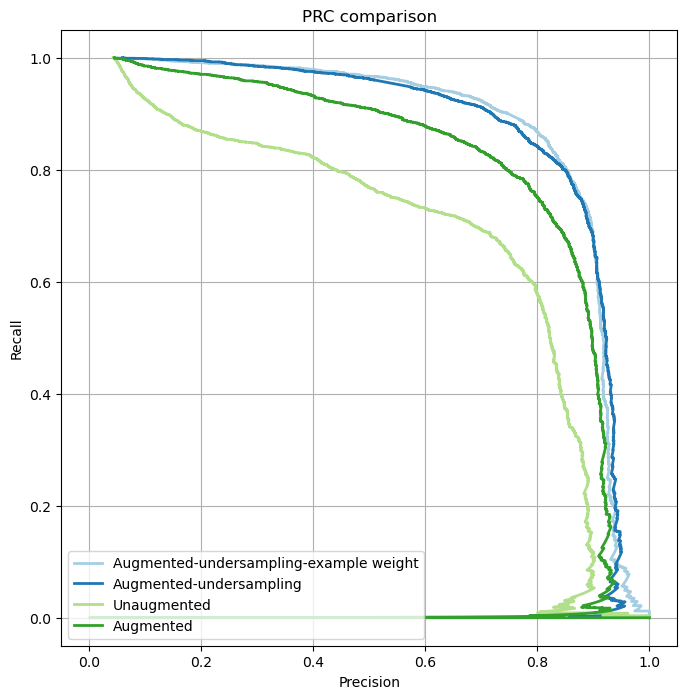

In [94]:
plot_prc("Augmented-undersampling-example weight", y_test, test_predictions_modelV2)
plot_prc("Augmented-undersampling", y_test, test_predictions_modelV1)
plot_prc("Unaugmented", y_test, test_predictions_modelV0)
plot_prc("Augmented", y_test, test_predictions_aug_modelV0)
plt.legend(loc='lower left')
plt.title('PRC comparison')

In [67]:
modelV2.save('aug_LSTM_model_V2.h5')